In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%load_ext autoreload

$$\dot{\theta} = \omega$$
$$\dot{\omega} = \frac{(m+m_c)g\sin{\theta} - \cos{\theta}(u + ml\omega^2\sin{\theta})}{(4/3)(m+m_c)l - ml\cos{\theta}^2}$$
$$\dot{h} = dh$$
$$\dot{dh} = \frac{u + ml(\omega^2\sin{\theta} - \dot{\omega}\cos{\theta})}{m + m_c}$$

In [3]:
from pendulum import InvertedPendulumSystem
from simulator import Simulator
from model import GaussianPDFModel, DiscreteModel
from optimizer import Optimizer
from policy_reinforce import PolicyREINFORCE
from monte_carlo import MonteCarloSimulationScenario
%autoreload 2

In [4]:
system = InvertedPendulumSystem()
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([0.0,0.0])
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array([-5 * observation[0] + -2 * observation[1]])

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("Angle")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Angular velocity")
# ax3.plot(np.array(observations)[:, 2])
# ax3.grid()
# ax3.set_title("horizontal distance")
# ax3.plot(np.array(observations)[:, 2])
# ax3.grid()
# ax3.set_title("horizontal distance")
# ax4.plot(np.array(observations)[:, 3])
# ax4.grid()
# ax4.set_title("horizontal angular")

IndexError: index 3 is out of bounds for axis 0 with size 2

# Reinforce

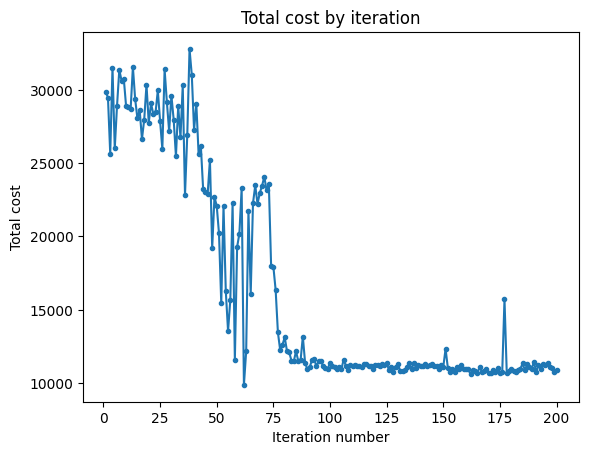

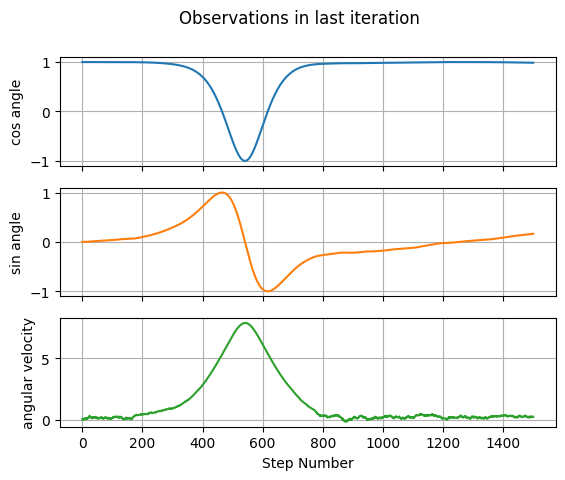

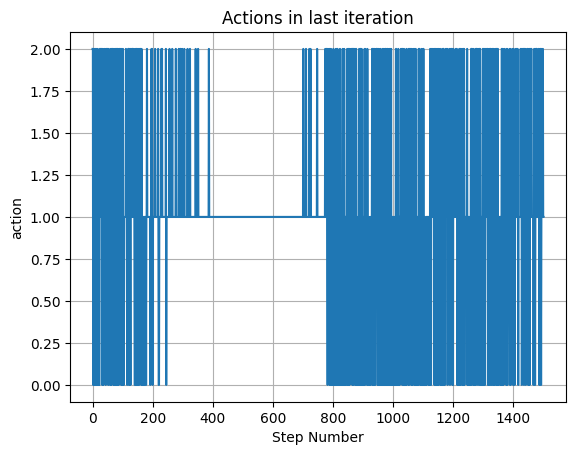

In [27]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem(f=10.0)

simulator = Simulator(
    system, N_steps=1500, step_size=0.003, state_init=np.array([0.0, 0.0])
)
# model = GaussianPDFModel(
#     dim_observation=system.dim_observation,
#     dim_action=system.dim_action,
#     action_bounds=np.array([[-10, 10]]),
#     scale_factor=1,  # TRY TO FIND scale_factor EMPIRICALLY
#     dim_hidden=32, # TRY TO FIND dim_hidden EMPIRICALLY
#     std=0.03, # TRY TO FIND STD EMPIRICALLY
#     n_hidden_layers=2 # TRY TO FIND STD EMPIRICALLY
# )

model = DiscreteModel(dim_observation=system.dim_observation,
                    dim_action=system.dim_action,
                    dim_hidden=32,
                    n_hidden_layers=2,dim_output=3)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.005), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20

# MAX_ANGLE = np.pi / 8
# MAX_X = 5
# termination_criterion = (
#     lambda observation, action, running_objective, total_objective: (
#         (np.abs(observation[0]) > MAX_ANGLE)# or (np.abs(observation[2]) > MAX_X)
#     )
# )


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    N_episodes=2, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=200, # You can change the number of iterations if you want
    termination_criterion=trivial_termination_criterion,
    discount_factor=1.0,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

In [28]:
from tqdm import tqdm

In [51]:
simulator.reset()
observations = []

i = 0
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()
    observations.append(observation)
    new_action = (
        policy.model.sample(torch.tensor(observation).float())
        .detach()
        .cpu()
        .numpy()
    )

    if i == 1000:
        new_action = float(new_action)
        new_action += np.random.uniform(50, 80)
        print(new_action)
    system.receive_action(new_action)
    i += 1

57.6376482728328


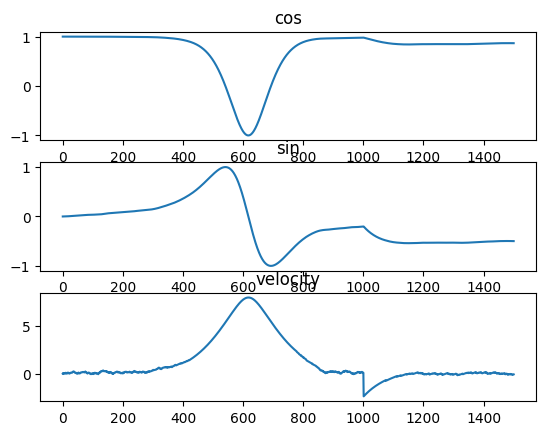

In [52]:
observations = np.array(observations)
fig, axes = plt.subplots(3, 1)

axes[0].plot(observations[:, 0])
axes[0].set_title('cos')
axes[1].plot(observations[:, 1])
axes[1].set_title('sin')
axes[2].plot(observations[:, 2])
axes[2].set_title('velocity')
plt.show()